# Загрузка данных

In [40]:
USE_FILE = 5            # номер используемго файла (см ниже)
PEAK_MIN_DISTANCE = 10  # минимальное расстояние между максимумами

In [41]:
# List of available data file names
# Список доступных файлов с данными
files = {
    1: "Checkme O2 _20250114084307.csv", 
    2: "Checkme O2 _20250119122308.csv", # запись в постели, я не сплю, но только что проснулся после длительного сна и еще не двигался
    3: "Checkme O2 _20250116013719.csv", # пример ночной записи с этапами сна в наморднике и без него, этапов просыпания
    4: "Checkme O2 _20250130232839.csv", # вначале я бодрствовал , потом спал без намордника
    5: "Checkme O2 _20250201233254.csv", # прислан 4 февраля
}

In [42]:
# Load the libraries
# Загрузка библиотек
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, savgol_filter

# Set the directory where the data files are located
# Установка директории, где находятся файлы с данными
DATADIR = "data"

In [43]:
# Load CSV into a pandas DataFrame
# Загрузить данные из CSV файла в датафрейм
filename = files[USE_FILE]
filename = os.path.join(DATADIR, filename)

df = pd.read_csv(
    filename,
    parse_dates=['Time'],
    date_format='%H:%M:%S %b %d %Y'
)

# Set Time as the index
# Использовать время как индекс
df.set_index('Time', inplace=True)

# Remove non-numeric values from df["Oxygen Level"]
# Удалить нечисловые значения из df["Oxygen Level"] (так как там мусор кроме чисел встречается)
df["Oxygen Level"] = pd.to_numeric(df["Oxygen Level"], errors='coerce')
df.dropna(subset=['Oxygen Level'], inplace=True)

# Отрисовка графика (до вырезания временного интервала)

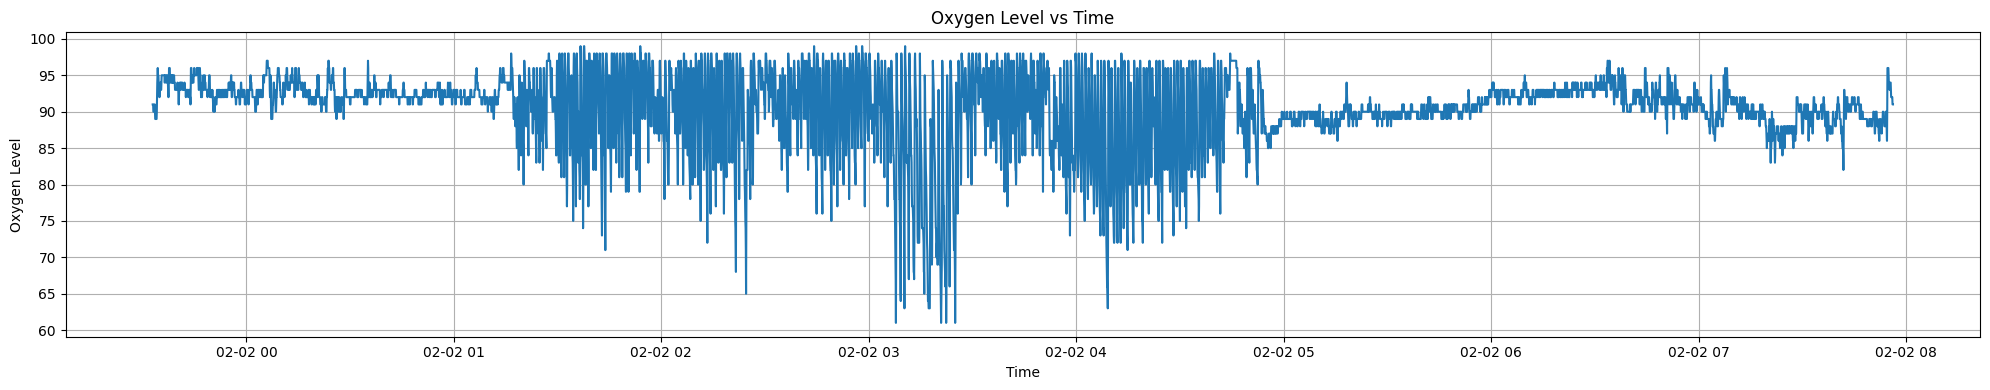

In [44]:
# Plot Oxygen Level vs. Time
# Построить график уровня кислорода от времени
plt.figure(figsize=(20, 4))
plt.plot(df.index, df['Oxygen Level'])
plt.xlabel('Time')
plt.ylabel('Oxygen Level')
plt.title('Oxygen Level vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Вырезание временного интервала

In [45]:
START_DATE = "2025-02-02 03:06:00" # начать с этой даты/времени (или None)
END_DATE = "2025-02-02 03:26:30"   # закончить с этой даты/времени (или None)

In [46]:
if START_DATE is not None:
    df = df.loc[START_DATE:]
if END_DATE is not None:
    df = df.loc[:END_DATE]

# Вывод исходных данных из выбранного веременного интервала (до сглаживания)

In [47]:
# Напечатать содержимое датафрейма
df

,Oxygen Level,Pulse Rate,Motion,O2 Reminder,PR Reminder
Time,,,,,
2025-02-02 03:06:02,94.0,60,0,0,0
2025-02-02 03:06:06,93.0,61,0,0,0
2025-02-02 03:06:10,90.0,59,0,0,0
2025-02-02 03:06:14,86.0,57,0,1,0
2025-02-02 03:06:18,83.0,52,0,0,0
...,...,...,...,...,...
2025-02-02 03:26:14,91.0,55,0,0,0
2025-02-02 03:26:18,90.0,58,0,0,0
2025-02-02 03:26:22,90.0,58,0,0,0


# Вычисление среднего и отрисовка графика (до сглаживания)

In [48]:
# Calculate the average oxygen level
# Вычислить средний уровень кислорода
average_O2 = df["Oxygen Level"].mean()

# Calculate the average oxygen level minus 3% - they use this threshold for apnea detection
# Вычислить средний уровень кислорода минус 3% - этот порог используется для обнаружения апноэ
average_O3_minus_3p = average_O2 * 0.97

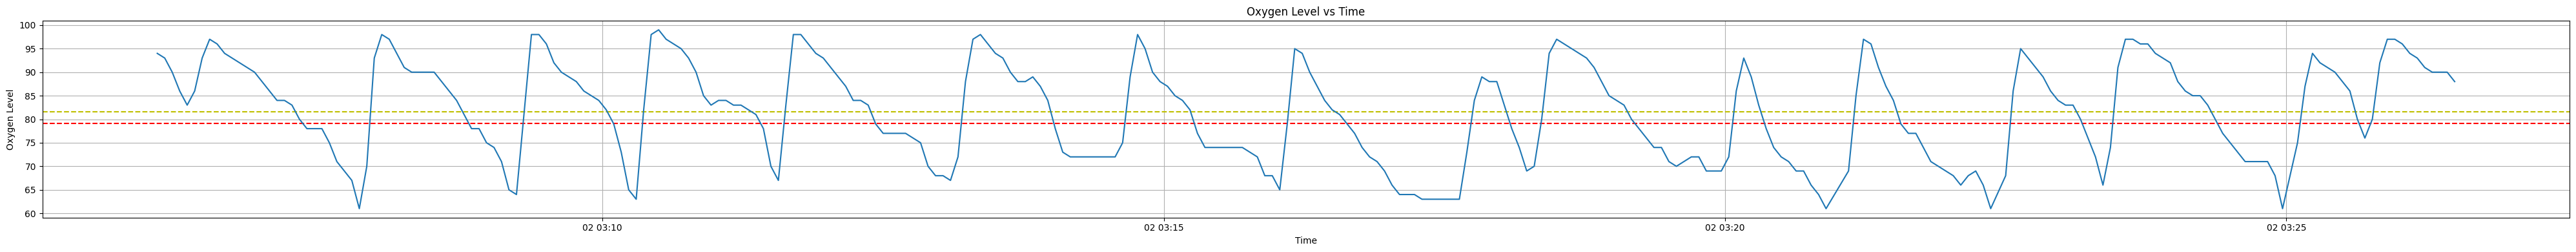

In [49]:
# Plot Oxygen Level vs. Time
# Построить график уровня кислорода от времени
plt.figure(figsize=(40, 4))
plt.axhline(average_O2, color='y', linestyle='--', label="Average O2")
plt.axhline(average_O3_minus_3p, color='r', linestyle='--', label="Average O2 - 3%")
plt.plot(df.index, df['Oxygen Level'])
plt.xlabel('Time')
plt.ylabel('Oxygen Level')
plt.title('Oxygen Level vs Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Сглаживание ряда

In [50]:
# длина окна сглаживания (в отсчетах)
window_length = None # 11 # None - без сглаживания
# порядок полинома сглаживания
polyorder = 2

In [51]:
# Smwindow_lengthooth the data series
# Сгладить временной ряд
if window_length is not None:
    df["O2_smooth"] = savgol_filter(df["Oxygen Level"], window_length=window_length, polyorder=polyorder)
else:
    df["O2_smooth"] = df["Oxygen Level"]

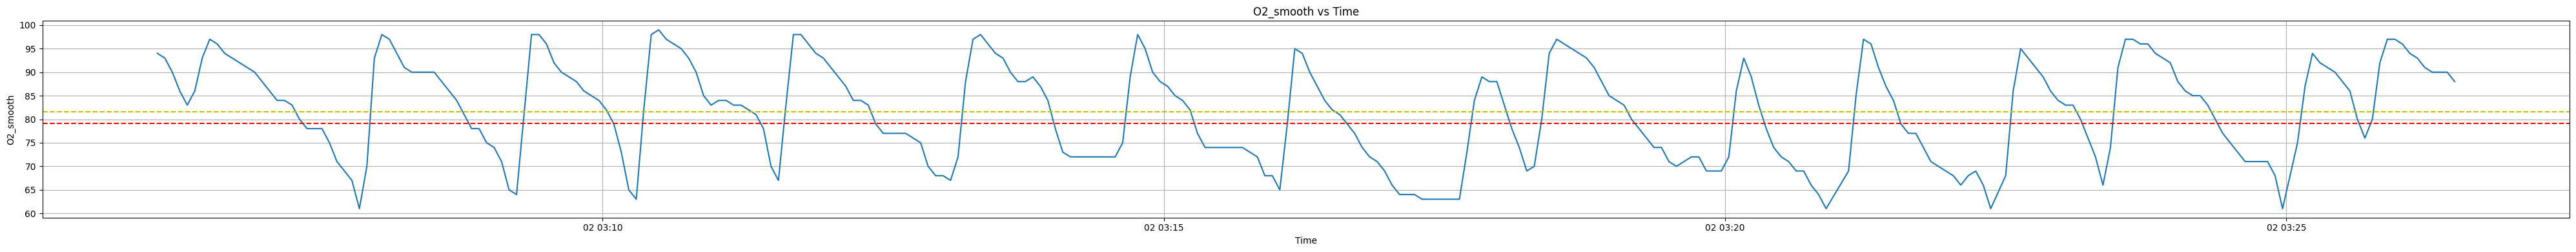

In [52]:
# Plot again
# Построить график снова
plt.figure(figsize=(40, 4))
plt.plot(df.index, df['O2_smooth'])
plt.axhline(average_O2, color='y', linestyle='--', label="Average O2")
plt.axhline(average_O3_minus_3p, color='r', linestyle='--', label="Average O2 - 3%")
plt.xlabel('Time')
plt.ylabel('O2_smooth')
plt.title('O2_smooth vs Time')
plt.grid(True)
plt.tight_layout()

# Анализ данных - разделение ряда на события между максимумами

In [53]:
# Use the smoothed O2 data to find peaks
# Использовать сглаженные данные O2 для поиска пиков
y = df["O2_smooth"].values

# Find_peaks returns indices in the array that are peak positions
# Find_peaks возвращает индексы в массиве, которые являются позициями пиков
peak_indices, peak_dict = find_peaks(
    y,
    distance=PEAK_MIN_DISTANCE,
)

# Convert indices back to your DataFrame index (Time)
# Преобразовать индексы обратно в индекс вашего датафрейма (Time)
peak_times = df.index[peak_indices]

# List of events, will hold (max1_idx, min_idx, max2_idx) for each event
# Список событий, будет содержать (max1_idx, min_idx, max2_idx) для каждого события
events = []

for i in range(len(peak_indices) - 1):
    # Start and end of one respiratory cycle
    # Начало и конец одного дыхательного цикла
    start_idx = peak_indices[i]
    end_idx   = peak_indices[i + 1]
    
    # Slice the O2 array in between these two peaks
    # Вырезать массив O2 между этими двумя пиками
    segment = y[start_idx : end_idx + 1]
    
    # Find the index of the min in this segment (relative to segment)
    # Найти индекс минимума в этом сегменте (относительно сегмента)
    min_local_idx = np.argmin(segment)
    
    # Convert that to an absolute index in the full data
    # Преобразовать его в абсолютный индекс в полных данных
    actual_min_idx = start_idx + min_local_idx
    
    # Store the triple: (start_of_cycle, the_minimum, next_peak)
    # Сохранить тройку: (начало_цикла, минимум, следующий_пик)
    events.append((peak_indices[i], actual_min_idx, peak_indices[i+1]))

# Отрисовка графика с выделенными пиками

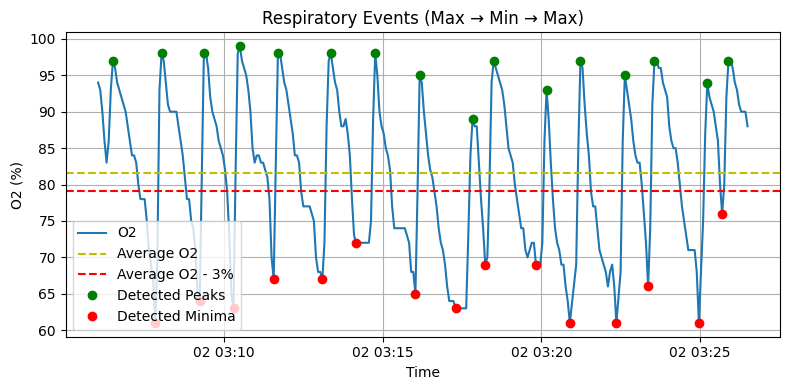

In [54]:
# Plot the smoothed O2 data, with the peaks and minima marked
# Построить сглаженные данные O2, с отмеченными пиками и минимумами
fig, ax = plt.subplots(figsize=(8, 4)) ### <<< эти два числа задают ширину и высоту графика

ax.plot(df.index, y, label="O2")
plt.axhline(average_O2, color='y', linestyle='--', label="Average O2")
plt.axhline(average_O3_minus_3p, color='r', linestyle='--', label="Average O2 - 3%")

ax.plot(df.index[peak_indices], y[peak_indices], 'go', label="Detected Peaks")
minima_indices = [ev[1] for ev in events]
ax.plot(df.index[minima_indices], y[minima_indices], 'ro', label="Detected Minima")

ax.set_xlabel("Time")
ax.set_ylabel("O2 (%)")
ax.set_title("Respiratory Events (Max → Min → Max)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

# Анализ - рассчет нагрузки

In [55]:
# List of analysis results
# Список результатов анализа
analysis = []

for (max1, min_, max2) in events:
    # Extract the O2 values for this event
    # Извлечь значения O2 для этого события
    o2_max1 = y[max1]
    o2_min  = y[min_]
    o2_max2 = y[max2]
    
    # Extract the times for this event
    # Извлечь времена для этого события
    time_max1 = df.index[max1]
    time_min  = df.index[min_]
    time_max2 = df.index[max2]
    
    # Calculate the amplitude of O2 drop
    # Вычислить амплитуду падения O2
    drop_amp = o2_max1 - o2_min 
    # Calculate the duration of the event
    # Вычислить длительность события
    duration = (time_max2 - time_max1).total_seconds() / 60.0  # in minutes, e.g.

    # Consider the second maximum value as the baseline
    # Считать второе максимальное значение базовым
    #baseline = o2_max2

    # IGNORE take an integral of the O2 values (under the baseline) in the event
    # IGNORE take into account that time between samples is not constant, but use 'Time' column to calculate the integral
    # IGNORE integral = np.trapz(y[min_:max2-1] - baseline)

    # calculate the desaturation load factor in percent-minutes
    # вычислить фактор нагрузки десатурации в процент-минутах
    desaturation_load = (o2_max2 - o2_min) * duration / 2.0
    #desaturation_load = integral / baseline * 100.0
    
    # Store the analysis results
    # Сохранить результаты анализа
    analysis.append({
        "start_time": time_max1,
        "min_time": time_min,
        "end_time": time_max2,
        "start_O2": o2_max1,
        "min_O2":   o2_min,
        "end_O2":   o2_max2,
        "drop_amp": drop_amp,
        "duration": duration,
        #"integral": integral,
        "desaturation_load": desaturation_load
    })

# Convert the analysis list to a DataFrame
# Преобразовать список анализа в датафрейм
analysis_df = pd.DataFrame(analysis)

# Вывод таблицы результатов анализа

In [56]:
# Print the analysis DataFrame
# Напечатать датафрейм анализа
analysis_df

,start_time,min_time,end_time,start_O2,min_O2,end_O2,drop_amp,duration,desaturation_load
0,2025-02-02 03:06:30,2025-02-02 03:07:50,2025-02-02 03:08:02,97.0,61.0,98.0,36.0,1.533333,28.366667
1,2025-02-02 03:08:02,2025-02-02 03:09:14,2025-02-02 03:09:22,98.0,64.0,98.0,34.0,1.333333,22.666667
2,2025-02-02 03:09:22,2025-02-02 03:10:18,2025-02-02 03:10:30,98.0,63.0,99.0,35.0,1.133333,20.400000
3,2025-02-02 03:10:30,2025-02-02 03:11:34,2025-02-02 03:11:42,99.0,67.0,98.0,32.0,1.200000,18.600000
4,2025-02-02 03:11:42,2025-02-02 03:13:06,2025-02-02 03:13:22,98.0,67.0,98.0,31.0,1.666667,25.833333
5,2025-02-02 03:13:22,2025-02-02 03:14:10,2025-02-02 03:14:46,98.0,72.0,98.0,26.0,1.400000,18.200000
6,2025-02-02 03:14:46,2025-02-02 03:16:02,2025-02-02 03:16:10,98.0,65.0,95.0,33.0,1.400000,21.000000
7,2025-02-02 03:16:10,2025-02-02 03:17:18,2025-02-02 03:17:50,95.0,63.0,89.0,32.0,1.666667,21.666667
8,2025-02-02 03:17:50,2025-02-02 03:18:14,2025-02-02 03:18:30,89.0,69.0,97.0,20.0,0.666667,9.333333
9,2025-02-02 03:18:30,2025-02-02 03:19:50,2025-02-02 03:20:10,97.0,69.0,93.0,28.0,1.666667,20.000000


# Статистическая обработка нагрузки

<Axes: >

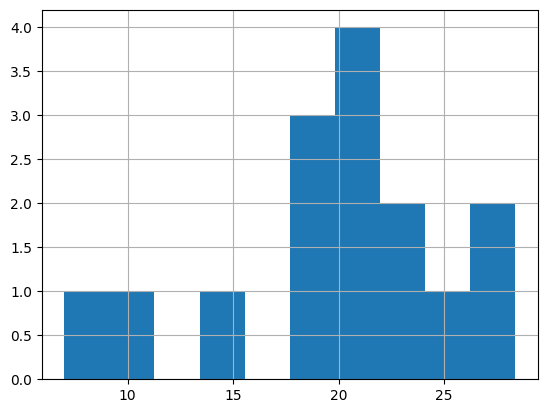

In [57]:
desaturation_load = analysis_df['desaturation_load']
desaturation_load.hist()

In [58]:
print(f"среднее \t{desaturation_load.mean()}\nдевиация\t{desaturation_load.std()}\nминимум \t{desaturation_load.min()}\nмаксимум\t{desaturation_load.max()}")

среднее 	19.868888888888886
девиация	6.004435750114133
минимум 	7.0
максимум	28.366666666666667
